In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
from tqdm.notebook import tqdm

In [2]:
from skmixed.lme.problems import LinearLMEProblem
from skmixed.lme.oracles import LinearLMEOracle
from skmixed.lme.models import LinearLMESparseModel

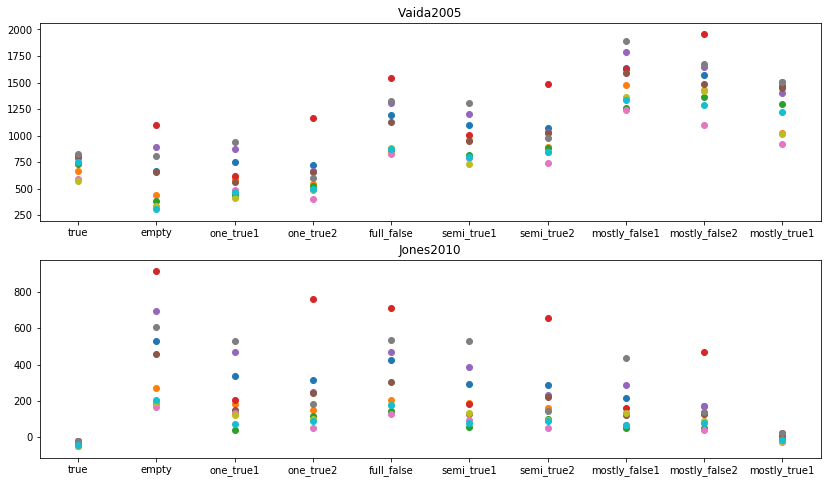

In [10]:
fig = plt.figure(figsize(14, 8))
grid = plt.GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :])
ax1.set_title("Vaida2005")
ax2.set_title("Jones2010")

for seed in tqdm(range(10)):

    problem, true_parameters = LinearLMEProblem.generate(groups_sizes=[40, 30, 50],
                                                        features_labels=[3, 3, 6, 5, 5, 6],
                                                        random_intercept=True,
                                                        obs_std=0.1,
                                                        seed=seed)
    true_beta = true_parameters['beta']
    true_gamma = true_parameters['gamma']

    correctly_pivoted_problem = problem.pivot((0, 2, 3))
    correct_oracle = LinearLMEOracle(correctly_pivoted_problem)
    jones2010bic_ref = correct_oracle.jones2010bic(true_beta, true_gamma)
    vaida2005aic_ref = correct_oracle.vaida2005aic(true_beta, true_gamma)

    features_idxs = {
        "true": (0, 2, 3),
        "empty": (0, ),
        "one_true1": (0, 2), 
        "one_true2": (0, 3), 
        "full_false": (0, 1, 4),
        "semi_true1": (0, 1, 2),
        "semi_true2": (0, 3, 4),
        "mostly_false1": (0, 1, 2, 4),
        "mostly_false2": (0, 1, 3, 4),
        "mostly_true1": (0, 2, 3, 4),
    }


    vaida2005aics = []
    jones2010bics = []
    labels = []
    for label, categorical_feature_idx in features_idxs.items():
        pivoted_problem = problem.pivot(categorical_feature_idx)
        X, y = pivoted_problem.to_x_y()
        model = LinearLMESparseModel(lb=0, lg=0, initializer="EM") # no regularization 
        model.fit(X, y)
        pred_beta = model.coef_['beta']
        pred_gamma = model.coef_['gamma']
        oracle = LinearLMEOracle(pivoted_problem)
        vaida2005aics.append(oracle.vaida2005aic(pred_beta, pred_gamma))
        jones2010bics.append(oracle.jones2010bic(pred_beta, pred_gamma))
        labels.append(label)
        
    ax1.scatter(labels, vaida2005aics)
    ax2.scatter(labels, jones2010bics)
plt.show()

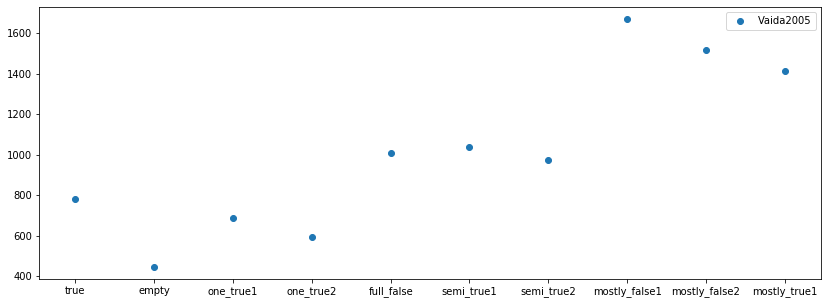

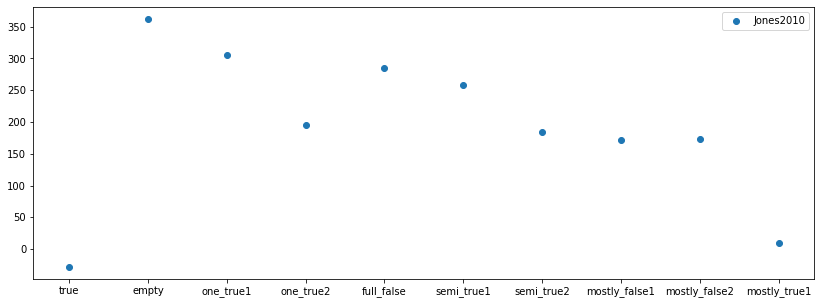

In [34]:
plt.figure(figsize=(14, 5))
plt.scatter(labels, vaida2005aics, label="Vaida2005")
plt.legend()
plt.show()
plt.figure(figsize=(14, 5))
plt.scatter(labels, jones2010bics, label="Jones2010")
plt.legend()

In [23]:
jones2010bic_ref

-45.43641442978108

In [24]:
vaida2005aic_ref

713.94156534771